<center><h1>KIM_GUKIL_HW4</h1></center>
<br>
<br>

Name: GUK IL KIM
<br>
Github Username: DanielKim12
<br>
USC ID: 3020867072

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

In [8]:
import numpy as np
import pandas as pd
import os
from scipy.stats import bootstrap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
import warnings
warnings.filterwarnings('ignore')

Get the AReM Data Set

### (b) Splitting Data

In [9]:
PATH = "../data/AReM/"

In [10]:
#for features extraction
def get_feature(key):
    if key == '50%':
        return 'median'
    elif key == '25%':
        return '1st quart'
    elif key == '75%':
        return '3rd quart'
    elif key == 'std':
        return 'standard deviation'
    elif key == 'min':
        return 'min'
    elif key == 'max':
        return 'max'
    elif key == 'mean':
        return 'mean'
    else:
        raise ValueError(f"Unknown feature shorthand: {key}")


In [11]:
def get_class(name):
    class_labels = {
        'bending1': 0,
        'bending2': 1,
        'cycling': 2,
        'lying': 3,
        'sitting': 4,
        'standing': 5,
        'walking': 6
    }
    return class_labels.get(name, -1)

In [12]:
#bending = 1 / non-bending = 0
def get_binary(class_value):
    if class_value == 1:
        return 'bending'
    elif class_value == 0:
        return 'non-bending'
    else:
        raise ValueError(f"Unknown class value: {class_value}")

In [14]:
# Load data from the files
files = {}
for folder in os.listdir(PATH):
    if folder.startswith('.') or 'pdf' in folder:
        continue
    for file in os.listdir(os.path.join(PATH, folder)):
        key = os.path.join(PATH, folder, file)
        files[key] = pd.read_csv(key, skiprows=4, usecols=range(7))
        # Remove the first column
        files[key].drop(files[key].columns[0], axis=1, inplace=True) 

# Map train and test data
train_data_map = {}
test_data_map = {}
for folder in os.listdir(PATH):
    if folder.startswith('.'):
        continue
    for file in os.listdir(os.path.join(PATH, folder)):
        file_name = os.path.join(PATH, folder, file)
        # Determine if the file is for the test or train dataset
        if folder in ['bending1', 'bending2']:
            if file not in ['dataset1.csv', 'dataset2.csv']:
                train_data_map[file_name] = files[file_name]
            else:
                test_data_map[file_name] = files[file_name]
        else:
            # For other activities
            if file not in ['dataset1.csv', 'dataset2.csv', 'dataset3.csv']:
                train_data_map[file_name] = files[file_name]
            else:
                test_data_map[file_name] = files[file_name]
# Print the number of files in the train and test datasets
print("Total Train Dataset Files: ", len(train_data_map))
print("Total Test Dataset Files: ", len(test_data_map))

# Function to split the dataset into train and test sets
def split_dataset(path):
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    folders = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]
    for folder in folders:
        folder_path = os.path.join(path, folder)
        if not os.path.exists(folder_path):
            continue
        files = sorted(os.listdir(folder_path))
        
        # Determine the number of test files based on the folder
        if folder in ['bending1', 'bending2']:
            test_files = files[:2]  # First 2 files for test set
        else:
            test_files = files[:3]  # First 3 files for test set
        
        # Load and concatenate test data
        for file in test_files:
            file_path = os.path.join(folder_path, file)
            data = pd.read_csv(file_path, skiprows=4, usecols=range(7))
            df_test = pd.concat([df_test, data], ignore_index=True)

        # Load and concatenate training data
        for file in files[len(test_files):]:
            file_path = os.path.join(folder_path, file)
            data = pd.read_csv(file_path, skiprows=4, usecols=range(7))
            df_train = pd.concat([df_train, data], ignore_index=True)

    # Print shapes of train and test datasets
    print("Train shape: ", df_train.shape)
    print("Test shape: ", df_test.shape)

    return df_train, df_test

# Example usage:
df_train, df_test = split_dataset(PATH)

Total Train Dataset Files:  69
Total Test Dataset Files:  19
Train shape:  (33119, 7)
Test shape:  (9120, 7)


### (c) Feature Extraction

##### From hw3

In [15]:
def extract_data(path):
    data = []
    # Iterate through the folders in the specified path
    for folder in os.listdir(path):
        # Construct the full path to the folder
        folder_path = os.path.join(path, folder)
        # Skip non-directory files and folders like .DS_Store or those with 'pdf' in the name
        if not os.path.isdir(folder_path) or 'pdf' in folder:
            continue
        # List and read all CSV files within the folder
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            # Read CSV file, skipping the first 4 rows and selecting the first 7 columns
            df = pd.read_csv(file_path, skiprows=4, usecols=range(7))
            data.append(df)
    return data


In [16]:
def extract_time_domain_features(data):
    # Define the names of the features (time domain)
    time_series_strings = ['min', 'max', 'mean', 'median', 'standard deviation', '1st quartile', '3rd quartile']
    
    # Create column names for each time series (1 through 6)
    columns = []
    for i in range(1, 7):
        columns.extend([f'{feature}_{i}' for feature in time_series_strings])
    
    # Create an empty DataFrame with the desired columns
    df = pd.DataFrame(columns=columns)
    
    # Iterate through each dataset
    for d in data:
        # Get descriptive statistics for the dataset
        summary = d.describe()
        row = []
        
        # Extract the summary statistics for each time series (1 through 6)
        for i in range(1, 7):
            row.append(summary.iloc[3, i])  # Min, 4th row of describe()
            row.append(summary.iloc[7, i])  # Max, 8th row of describe()
            row.append(summary.iloc[1, i])  # Mean, 2nd row of describe()
            row.append(summary.iloc[5, i])  # Median, 6th row of describe()
            row.append(summary.iloc[2, i])  # Standard deviation, 3rd row of describe()
            row.append(summary.iloc[4, i])  # 1st quartile, 5th row of describe()
            row.append(summary.iloc[6, i])  # 3rd quartile, 7th row of describe()
        
        # Append the row as a new DataFrame row
        df = df.append(pd.DataFrame([row], columns=columns), ignore_index=True)
    display(df)
    return df



extract_time_domain() modified a bit from using dict to list 

In [17]:
data = extract_data(PATH)
extracted_df = extract_time_domain_features(data)

min_1  max_1     mean_1  median_1  standard deviation_1  1st quartile_1  \
0   36.25  48.00  43.969125     44.50              1.618364         43.3100   
1   37.00  48.00  43.454958     43.25              1.386098         42.5000   
2   33.00  47.75  42.179812     43.50              3.670666         39.1500   
3   33.00  45.75  41.678063     41.75              2.243490         41.3300   
4   37.25  45.00  40.624792     40.50              1.476967         39.2500   
..    ...    ...        ...       ...                   ...             ...   
83  18.50  44.25  35.752354     36.00              4.614802         33.0000   
84  24.25  45.00  37.177042     36.25              3.581301         34.5000   
85  23.33  43.50  36.244083     36.75              3.822016         33.4575   
86  26.25  44.25  36.957458     36.29              3.434863         34.5000   
87  27.75  44.67  37.144833     36.33              3.758904         34.0000   

    3rd quartile_1  min_2  max_2    mean_2  ...  standard deviation_5  \
0            44.67    0.0   1.50  0.413125  ...              3.318301   
1            45.00    0.0   1.58  0.378083  ...              2.488862   
2            45.00    0.0   3.00  0.696042  ...              3.849448   
3            42.75    0.0   2.83  0.535979  ...              2.411026   
4            42.00    0.0   1.30  0.358604  ...              2.188449   
..             ...    ...    ...       ...  ...                   ...   
83           39.33    0.0  12.60  3.328104  ...              3.120057   
84           40.25    0.0   8.58  2.374208  ...              2.890347   
85           39.25    0.0   9.71  2.736021  ...              3.617702   
86           40.25    0.0   8.64  2.420083  ...              2.851673   
87           40.50    0.0  10.76  2.419062  ...              2.689291   

    1st quartile_5  3rd quartile_5  min_6  max_6    mean_6  median_6  \
0          20.5000         23.7500    0.0   2.96  0.555312     0.490   
1          22.2500         24.0000    0.0   5.26  0.679646     0.500   
2          30.4575         36.3300    0.0   2.18  0.613521     0.500   
3          28.4575         31.2500    0.0   1.79  0.383292     0.430   
4          33.0000         36.0000    0.0   1.92  0.570583     0.430   
..             ...             ...    ...    ...       ...       ...   
83         14.0000         18.0625    0.0   9.39  3.069667     2.770   
84         17.9500         21.7500    0.0   9.34  2.921729     2.500   
85         15.7500         21.0000    0.0  11.15  3.530500     3.110   
86         14.0000         18.2500    0.0   8.34  2.934625     2.525   
87         15.0000         18.7500    0.0   8.75  2.822437     2.590   

    standard deviation_6  1st quartile_6  3rd quartile_6  
0               0.487826          0.0000          0.8300  
1               0.622534          0.4300          0.8700  
2               0.524317          0.0000          1.0000  
3               0.389164          0.0000          0.5000  
4               0.582915          0.0000          1.3000  
..                   ...             ...             ...  
83              1.748326          1.7975          4.0600  
84              1.852600          1.5000          3.9000  
85              1.963685          2.1700          4.6175  
86              1.631380          1.6600          4.0300  
87              1.637183          1.5800          3.7400  

[88 rows x 42 columns]

In [12]:
extracted_df.describe().loc[['std']]

min_1     max_1    mean_1  median_1  standard deviation_1  \
std  9.569975  4.394362  5.335718  5.440054              1.772153   

     1st quartile_1  3rd quartile_1  min_2     max_2    mean_2  ...  \
std         6.15359        5.138925    0.0  5.062729  1.574164  ...   

     standard deviation_5  1st quartile_5  3rd quartile_5     min_6     max_6  \
std              1.024898        6.096465         5.53172  0.045838  2.518921   

       mean_6  median_6  standard deviation_6  1st quartile_6  3rd quartile_6  
std  1.154812  1.086474              0.517617        0.758584        1.523599  

[1 rows x 42 columns]

In [13]:
# Create an empty DataFrame to store the 90% confidence intervals
CI_90 = pd.DataFrame()
# Iterate through each column in the DataFrame
for col in range(len(extracted_df.columns)):
    # Extract the data from the column
    data = (extracted_df.iloc[:, col],)
    res = bootstrap(data, np.std, confidence_level = 0.9, random_state = 1, method = 'percentile')
    paired_CI = f"low={res.confidence_interval.low:.4f}, high={res.confidence_interval.high:.4f}"
    # Create a DataFrame row for this column
    temp = pd.DataFrame({
        'Feature': [extracted_df.columns[col]], 
        '90% CI': [paired_CI]
    }, index=[col+1])
     # Append to CI_90 DataFrame
    CI_90 = pd.concat([CI_90, temp], ignore_index=True)
CI_90

Feature                    90% CI
0                  min_1  low=8.2173, high=10.7042
1                  max_1   low=3.3060, high=5.2691
2                 mean_1   low=4.6752, high=5.8371
3               median_1   low=4.7603, high=5.9646
4   standard deviation_1   low=1.5628, high=1.9356
5         1st quartile_1   low=5.5423, high=6.6038
6         3rd quartile_1   low=4.3089, high=5.8070
7                  min_2   low=0.0000, high=0.0000
8                  max_2   low=4.5951, high=5.3774
9                 mean_2   low=1.3931, high=1.6981
10              median_2   low=1.2341, high=1.5363
11  standard deviation_2   low=0.7994, high=0.9377
12        1st quartile_2   low=0.8282, high=1.0306
13        3rd quartile_2   low=1.8893, high=2.2852
14                 min_3   low=2.7475, high=3.0929
15                 max_3   low=4.1568, high=5.4325
16                mean_3   low=3.4004, high=4.4680
17              median_3   low=3.4094, high=4.5079
18  standard deviation_3   low=0.7584, high=1.1127
19        1st quartile_3   low=3.6143, high=4.6759
20        3rd quartile_3   low=3.5208, high=4.6653
21                 min_4   low=0.0000, high=0.0000
22                 max_4   low=1.9664, high=2.3487
23                mean_4   low=1.0701, high=1.2149
24              median_4   low=1.0485, high=1.1942
25  standard deviation_4   low=0.4197, high=0.4841
26        1st quartile_4   low=0.7714, high=0.8855
27        3rd quartile_4   low=1.4251, high=1.6174
28                 min_5   low=4.3887, high=7.4503
29                 max_5   low=4.7084, high=6.5352
30                mean_5   low=4.4068, high=6.6764
31              median_5   low=4.4907, high=6.8497
32  standard deviation_5   low=0.8056, high=1.2119
33        1st quartile_5   low=4.7759, high=7.1448
34        3rd quartile_5   low=4.3407, high=6.4778
35                 min_6   low=0.0000, high=0.0780
36                 max_6   low=2.2366, high=2.7479
37                mean_6   low=1.0575, high=1.2077
38              median_6   low=0.9909, high=1.1415
39  standard deviation_6   low=0.4769, high=0.5419
40        1st quartile_6   low=0.6869, high=0.8033
41        3rd quartile_6   low=1.3959, high=1.5912

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

In [4]:
# initialize the class labels
features = ['mean', 'median', 'std'] 
time_series = ['avg_rss12', 'var_rss12', 'avg_rss23']

In [5]:
# Extract features for the training dataset
def extract_features(time_series, feature_names, split):
    generated_feature_names = []
    for split_no in range(split):
        for time_series_col in time_series:
            for feature in feature_names:
                # Generate feature name by combining the time series, feature, and split number
                generated_feature_names.append(f"{time_series_col}_{feature}_split{split_no + 1}")
    generated_feature_names.append('type')  # Append the class label at the end
    return generated_feature_names

In [18]:
def modify_data(data, split, headers, time_series, features, is_bending=True):
    processed_data = []
    for key, df in data.items():
        segments = np.array_split(df, split)
        instance_features = []
        for split_no, segment in enumerate(segments):
            # Calculate summary statistics using describe() and median separately
            segment_stats = segment.describe()
            medians = segment.median()  # Explicitly calculate medians
            
            for series in time_series:
                for feature in features:
                    if feature == 'median':  # Handle the case where 'median' is specified
                        instance_features.append(medians[series])
                    else:
                        instance_features.append(segment_stats[series][feature])
        # Append the class label using the path to extract the class (bending or not)
        val = key.split("/")[3]
        if is_bending:
            if 'bending' in val:
                instance_features.append(1)  # Class for bending
            else:
                instance_features.append(0)  # Class for non-bending
        else:
            instance_features.append(get_class(val))  # Use get_class() if not bending
        processed_data.append(instance_features)
    return pd.DataFrame(processed_data, columns=headers)


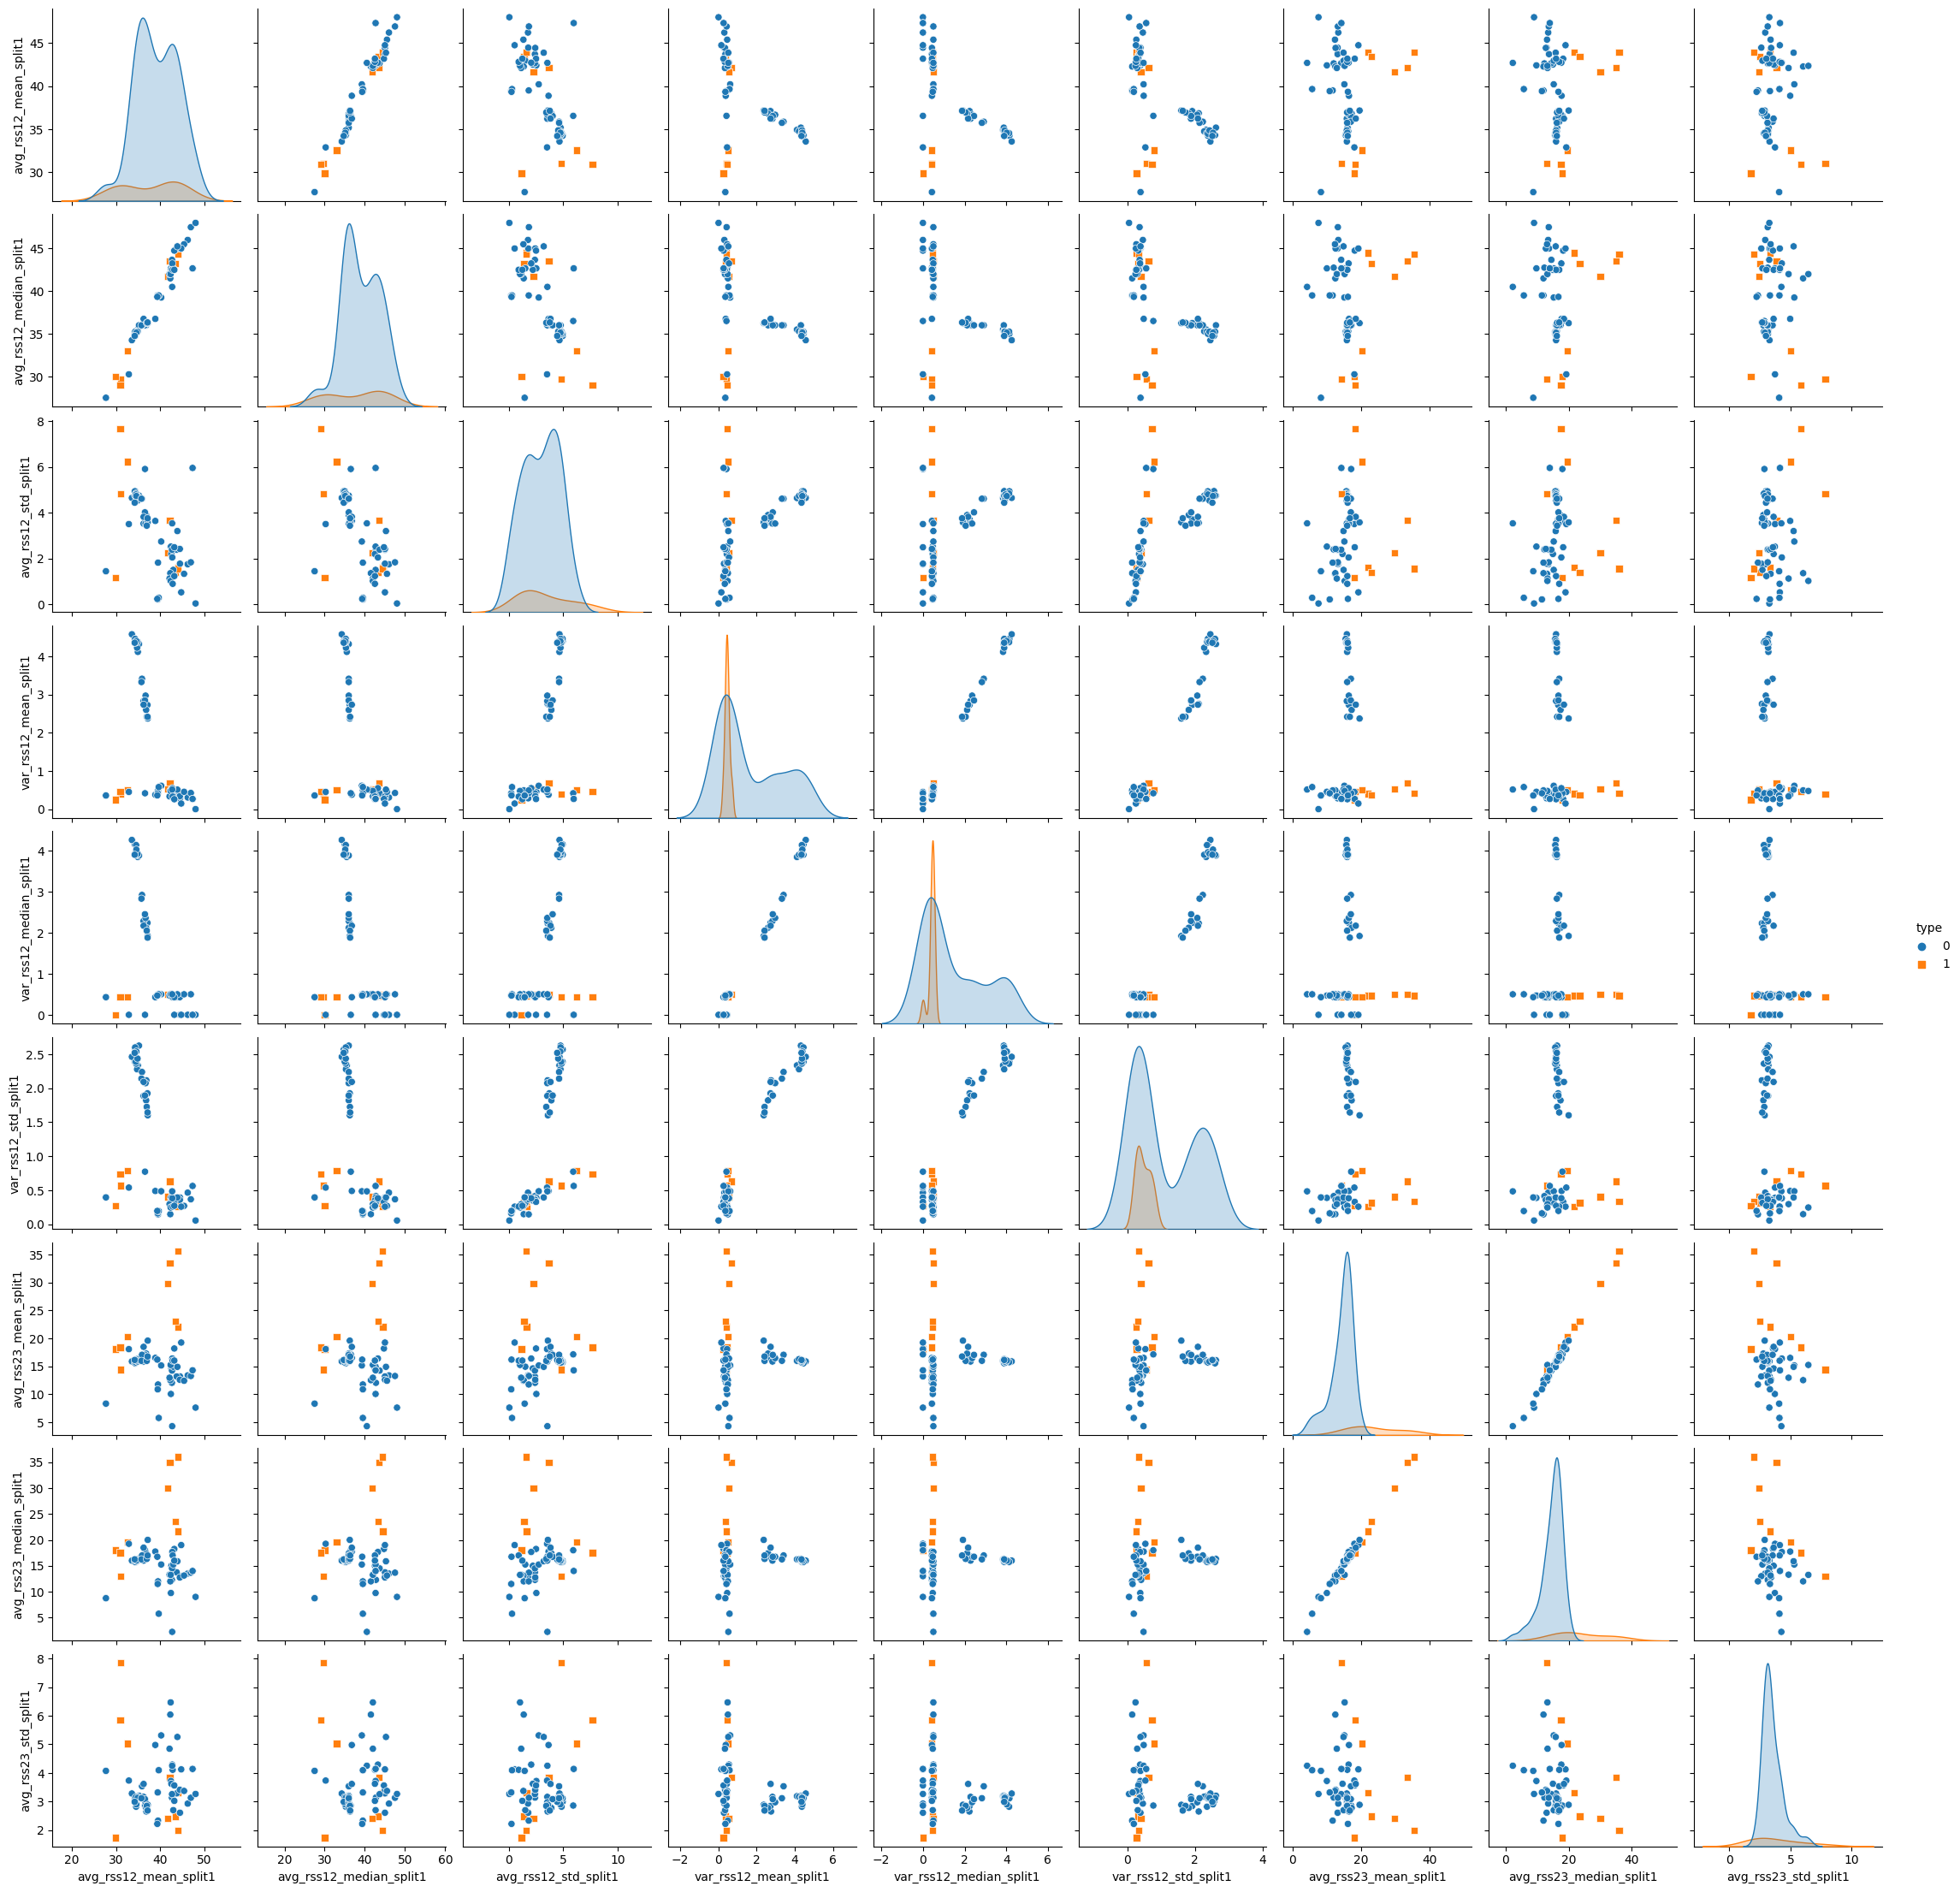

In [25]:
split = 1
headers = extract_features(time_series, features, split)
train_data = modify_data(train_data_map, split, headers, time_series, features)
sns.pairplot(data=train_data, hue='type', markers=["o", "s"])
plt.show()

For both plots (0 = non-bending) and (1 = bending). 

#### ii. Splitted Plots

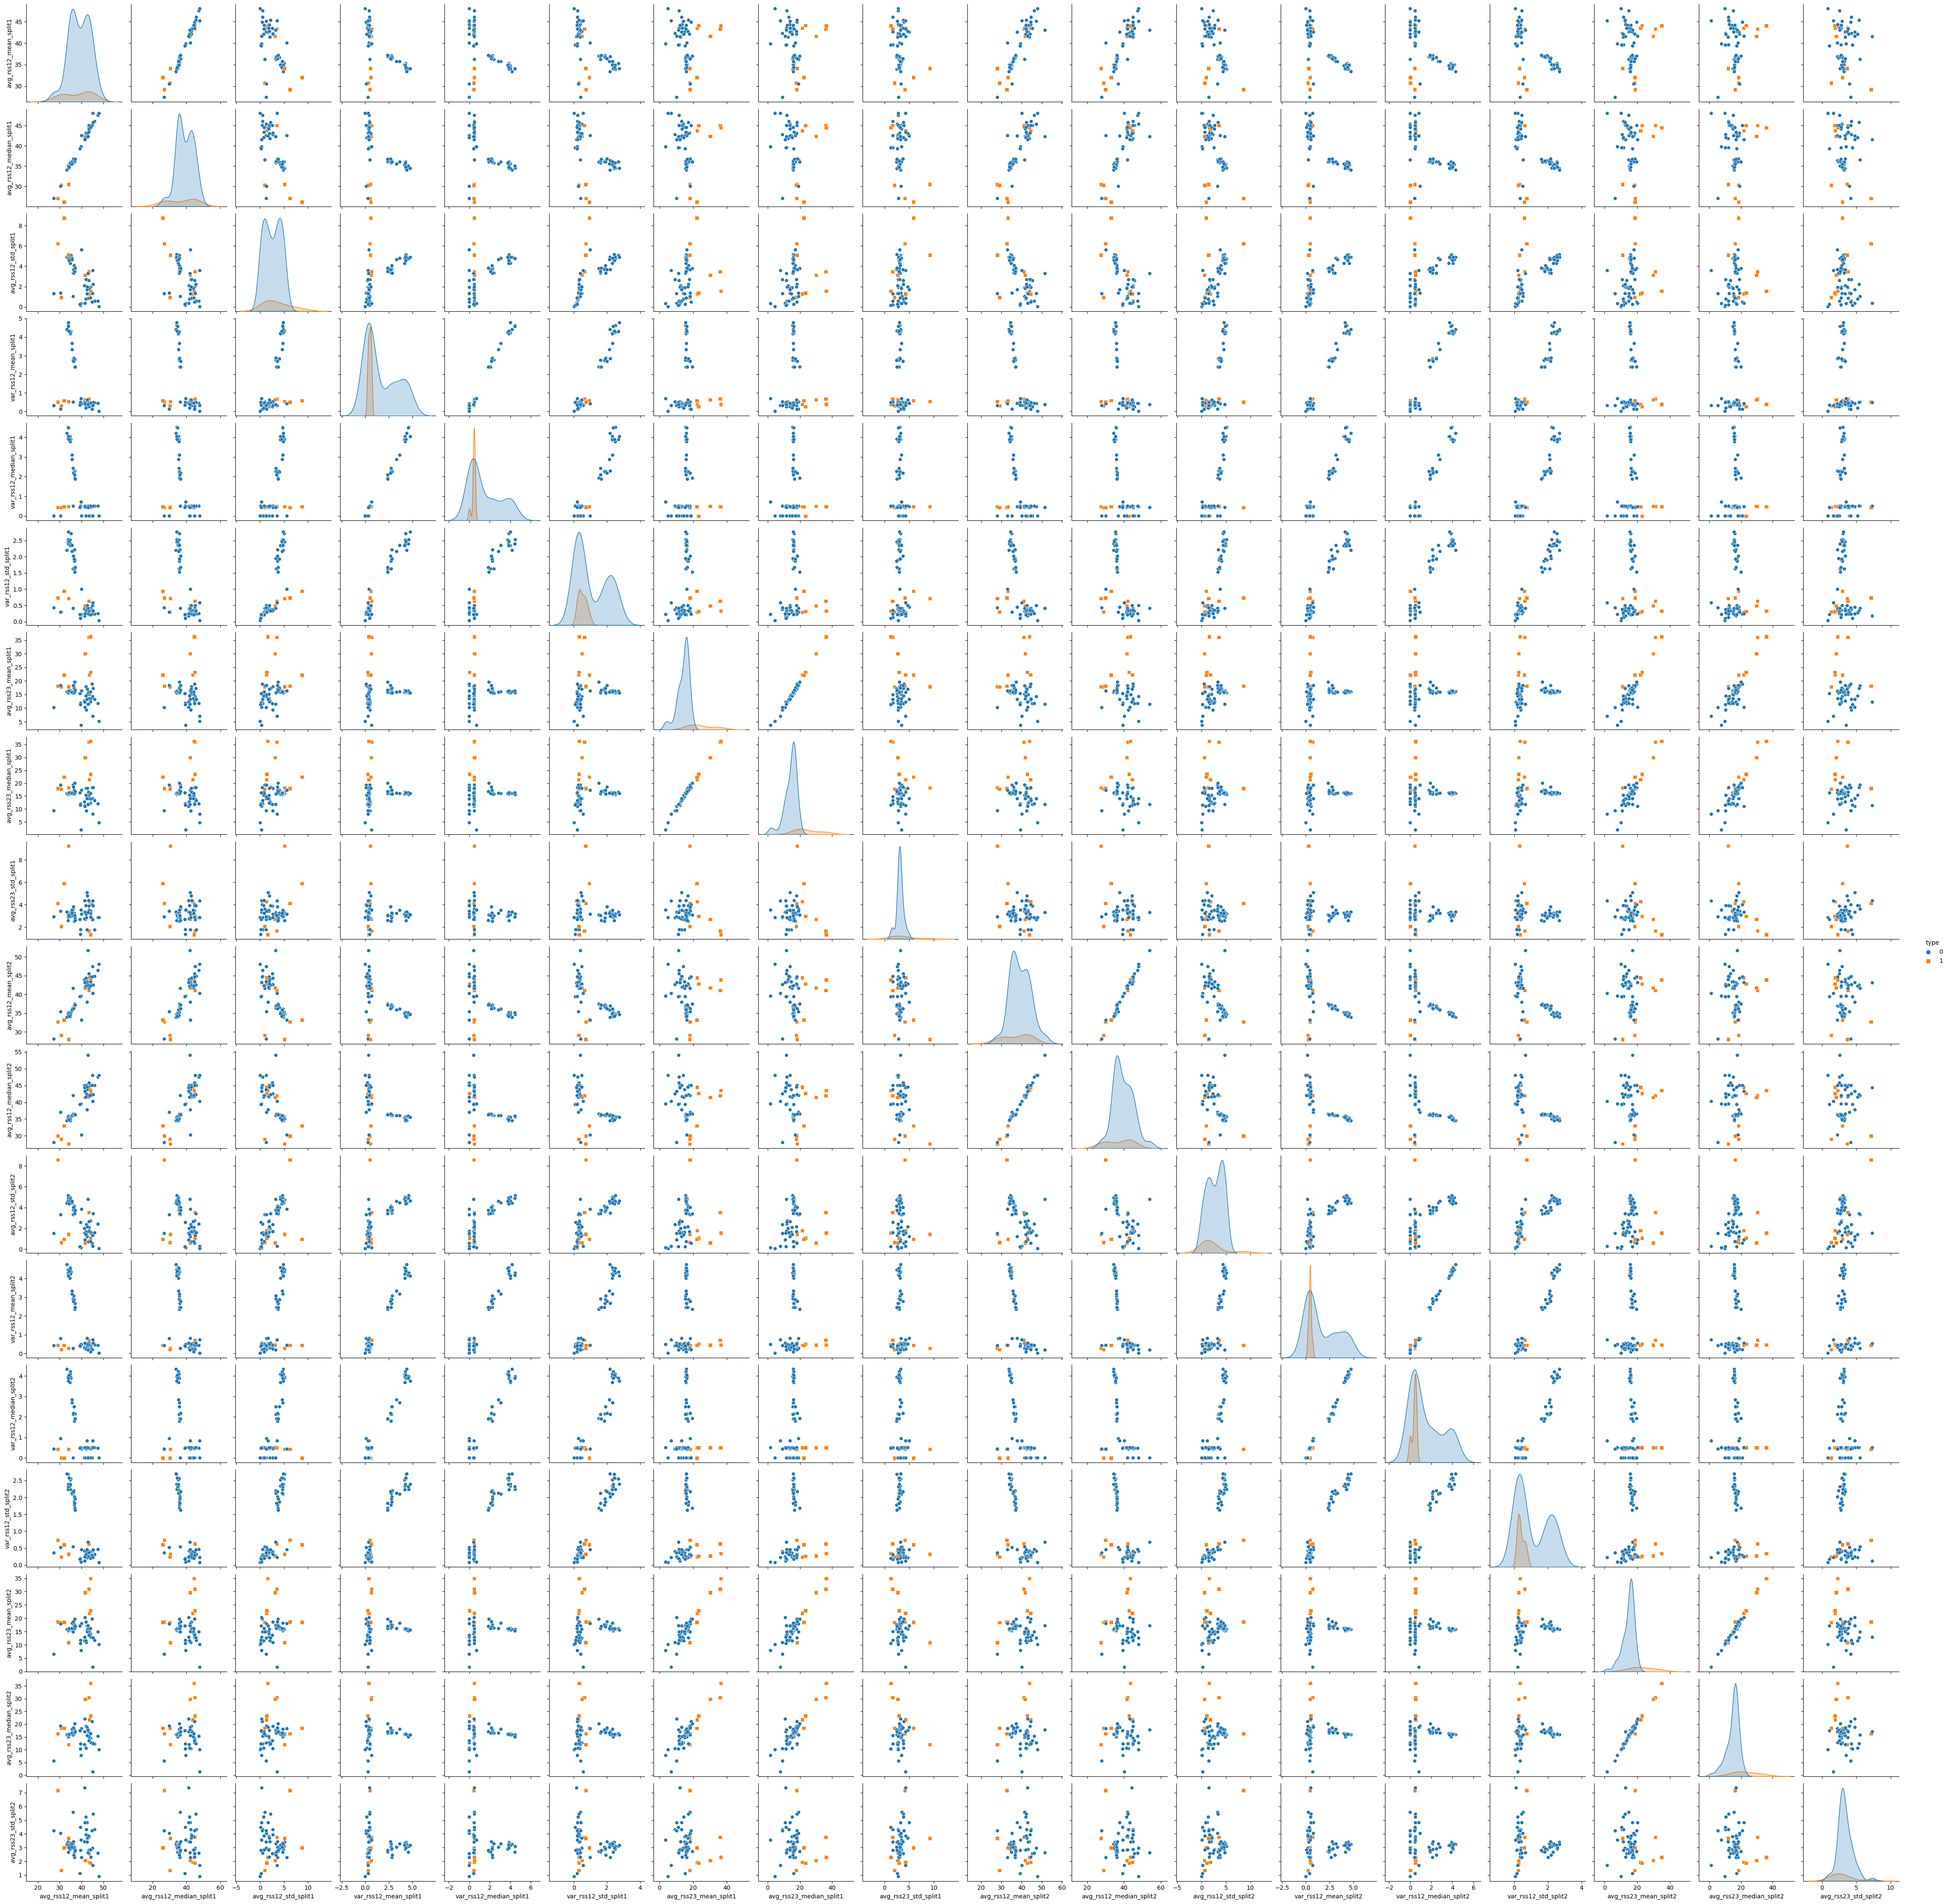

In [24]:
split = 2 
headers = extract_features(time_series, features, split)
train_data = modify_data(train_data_map, split, headers, time_series, features)
sns.pairplot(data=train_data, hue='type', markers=["o", "s"])
plt.show()

#### Observation: not much difference between two pairplots. 

#### iii. Time Series Segments

In [28]:
def oversample_imbalance_class(train_df):
    total0 = train_df.loc[train_df['type'] == 0].shape[0]
    total1 = train_df.loc[train_df['type'] == 1].shape[0]
    minor_label, major_label = (1, 0) if total0 > total1 else (0, 1)
    # Separate the classes based on the labels and resample the minority class
    minor_ds = train_df[train_df['type'] == minor_label]
    major_ds = train_df[train_df['type'] == major_label]
    # resample the minority class to match the majority class   
    minor_ds = resample(minor_ds, replace = True, random_state = 60, n_samples = max(total0, total1))
    train_df = pd.concat([major_ds, minor_ds])
    return train_df

In [26]:
time_series_features = ['min', 'max', 'mean', 'median', 'standard deviation', '1st quartile', '3rd quartile' ]
time_series_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
time_domain_features = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']

In [29]:
def logistic_regression(train_data_map, test_data_map, split, cv_fold, time_series = time_series_columns, features = time_domain_features, oversampling = False):
    # get features and data
    headers = extract_features(time_series, features, split)
    train_df = modify_data(train_data_map, split, headers, time_series, features)    
    # oversampling
    if oversampling:
        total0 = train_df.loc[train_df['type'] == 0].shape[0]
        total1 = train_df.loc[train_df['type'] == 1].shape[0]
        minor_label, major_label = (1, 0) if total0 > total1 else (0, 1)
        # oversampling the minority class
        minor_ds = train_df[train_df['type'] == minor_label]
        major_ds = train_df[train_df['type'] == major_label]
        # resampling
        minor_ds = resample(minor_ds, replace = True, random_state = 60, n_samples = max(total0, total1))
        train_df = pd.concat([major_ds, minor_ds])

    # spliting data to train X and label Y
    trainX = train_df.iloc[:, :-1]
    trainY = train_df.iloc[:, -1]
    # main model
    validator = StratifiedKFold(n_splits = cv_fold, shuffle = True, random_state = 69)
    model = LogisticRegression(penalty = 'none', solver = 'lbfgs', max_iter = 100)
    selector = RFECV(estimator = model, cv = validator, scoring = 'accuracy')
    selector.fit(trainX, trainY)
    test_accuracy = selector.cv_results_['mean_test_score'].max()
    return model, selector, round(test_accuracy, 5), round(1 - test_accuracy, 5)

In [30]:
cv_fold = 5
split_range = 20
Result = {'Split': [], 'Count of Features': [], 'Test Accuracy': [], 'Test Error': []}
for split in range(1, split_range + 1):
    model, selector, score, error = logistic_regression(train_data_map, test_data_map, split, cv_fold, features = features)
    Result['Split'].append(split)
    Result['Count of Features'].append(selector.n_features_)
    Result['Test Accuracy'].append(score)
    Result['Test Error'].append(error)

Result = pd.DataFrame(Result)
Result

Split  Count of Features  Test Accuracy  Test Error
0       1                 11        0.95714     0.04286
1       2                 35        0.94286     0.05714
2       3                  4        0.95714     0.04286
3       4                  3        0.97143     0.02857
4       5                  2        0.97143     0.02857
5       6                  4        0.97143     0.02857
6       7                  8        0.98571     0.01429
7       8                  3        0.97143     0.02857
8       9                 57        0.97143     0.02857
9      10                 92        0.98571     0.01429
10     11                 31        0.98571     0.01429
11     12                 33        0.97143     0.02857
12     13                 71        0.98571     0.01429
13     14                 46        0.97143     0.02857
14     15                 73        0.98571     0.01429
15     16                 63        0.97143     0.02857
16     17                 47        0.97143     0.02857
17     18                  1        0.98571     0.01429
18     19                 60        0.95714     0.04286
19     20                102        0.97143     0.02857

### report out:
- best (l = number of features,p = test accuracy) is (7, 8) according to the table above.
- The correct way to perform cross-validation is by applying RFE within the cross-validation process as performing RFE prior to cross-validation might discard important features as RFE selects features based on a signle dataset split.

#### iv. Confusion Matrix

### for Labels:
[    [0, 'bending1'],
    [1, 'bending2'],
    [2, 'cycling'],
    [3, 'lying'],
    [4, 'sitting'],
    [5, 'standing'],
    [6, 'walking']
]

In [31]:
def cm_roc_report(model, X, y, selected_features, test_data=False):
    # Fit the model if not test data
    if not test_data:
        model.fit(X[selected_features], y)
    # Predict and get probabilities
    pred_y = model.predict(X[selected_features])
    pred_y_prob = model.predict_proba(X[selected_features])
    # Generate Confusion Matrix
    print(f"Confusion Matrix:\n{confusion_matrix(y, pred_y)}")
    # Accuracy
    accuracy = model.score(X[selected_features], y)
    print(f"Accuracy: {accuracy:.4f}")
    # Plot ROC Curves
    _, axes = plt.subplots(figsize=(8, 6))
    axes.set_title("ROC Curves")
    for i, class_ in enumerate(model.classes_):
        y_pred = pred_y_prob[:, i]
        fpr, tpr, _ = roc_curve(y, y_pred, pos_label=class_)
        roc_auc = auc(fpr, tpr)
        axes.plot(fpr, tpr, label=f"Class: {class_}; AUC: {round(roc_auc, 4)}")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

Confusion Matrix:
[[60  0]
 [ 0  9]]
Accuracy: 1.0000


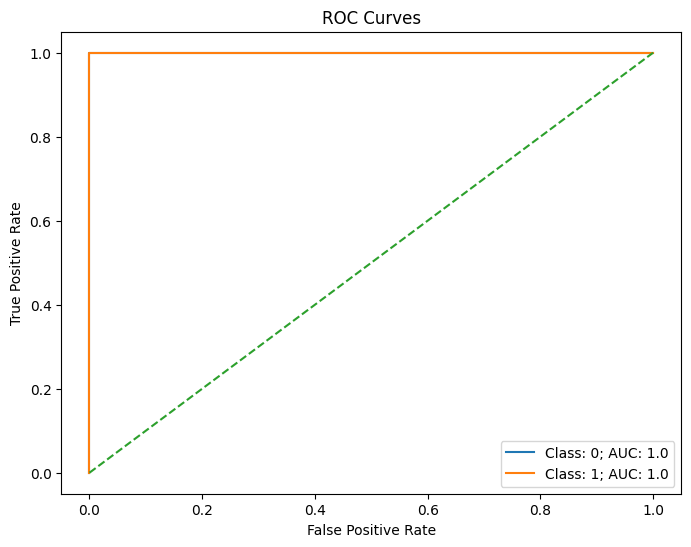

In [32]:
# Assuming logistic_regression function returns a trained model (model_lr), RFE selector, score, and error
top_res = Result['Test Accuracy'].argmax()
split = top_res + 1
cv_fold = 5

# Extract headers for the features
headers = extract_features(time_series_columns, features, split)

# Modify the train data using the headers
train_df = modify_data(train_data_map, split, headers, time_series_columns, features)

# Train a logistic regression model with feature selection and cross-validation
model_lr, selector, score, error = logistic_regression(train_data_map, test_data_map, split, cv_fold, features=features)

# Separate features (X) and labels (Y) from the training dataframe
trainX, trainY = train_df.iloc[:, :-1], train_df.iloc[:, -1]

# Select features chosen by Recursive Feature Elimination (RFE)
RFE_selected_features = []
for i, feature in enumerate(headers[:-1]):  # headers[:-1] to exclude the label column (last one is label)
    if selector.support_[i]:  # Check if the feature is selected by RFE
        RFE_selected_features.append(feature)

# Call the get_cm_roc_plot function (previously combined function) to get confusion matrix and plot ROC curve
cm_roc_report(model_lr, trainX, trainY, RFE_selected_features)


The ROC curve is shonwn above, and the AUC is calculated as 100%.

In [33]:
df_temp = trainX.loc[:, RFE_selected_features]
const_val = sm.add_constant(df_temp.to_numpy(dtype = float))
model = sm.Logit(trainY.to_numpy(dtype = float), const_val)
summary = model.fit(method = 'bfgs').summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       60
Method:                           MLE   Df Model:                            8
Date:                Sun, 20 Oct 2024   Pseudo R-squ.:                   1.000
Time:                        21:36:03   Log-Likelihood:            -1.6375e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 8.882e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6875   1.24e+07  -5.5

### Observing p-value:
- looking at the stats above, we can conclude that the data is completely seperated. This menas that the independent variables in model are perfectly predicting the outcome variable, which leads p-values of 1 for all coef. 

#### v. Test Classifier

In [34]:
split = top_res + 1
headers = extract_features(time_series_columns, features, split)
test_df = modify_data(test_data_map, split, headers, time_series_columns, features)  
testX, testY = test_df.iloc[:, :-1], test_df.iloc[:, -1]
test_df

avg_rss12_mean_split1  avg_rss12_median_split1  avg_rss12_std_split1  \
0               40.790000                    41.00              0.940505   
1               43.423913                    43.50              0.343007   
2               34.803768                    36.00              4.740425   
3               34.110580                    35.00              4.765596   
4               33.191739                    33.75              4.449958   
5               21.155797                    21.33              2.762022   
6               28.449130                    27.33              1.466543   
7               46.458841                    46.50              0.525566   
8               42.838986                    43.25              1.481226   
9               43.967536                    44.67              1.845600   
10              41.954203                    42.00              0.139489   
11              47.091739                    48.00              1.990385   
12              45.549130                    45.50              0.471408   
13              28.776667                    29.00              0.707123   
14              29.094058                    29.00              0.507978   
15              48.000000                    48.00              0.000000   
16              36.734348                    35.50              3.860542   
17              37.476087                    37.00              3.092440   
18              37.833333                    36.67              3.225387   

    var_rss12_mean_split1  var_rss12_median_split1  var_rss12_std_split1  \
0                0.498841                     0.50              0.200408   
1                0.558261                     0.50              0.141608   
2                3.708986                     3.54              2.264594   
3                4.415217                     3.70              2.603700   
4                4.856812                     4.74              2.307347   
5                0.951594                     0.71              1.037515   
6                0.085507                     0.00              0.196368   
7                0.451884                     0.50              0.203501   
8                0.539130                     0.50              0.310927   
9                0.440290                     0.43              0.368231   
10               0.067536                     0.00              0.165684   
11               0.332609                     0.00              0.742887   
12               0.391594                     0.47              0.230464   
13               0.228696                     0.00              0.297039   
14               0.233478                     0.00              0.267932   
15               0.000000                     0.00              0.000000   
16               2.354058                     2.17              1.329279   
17               2.112174                     1.92              1.194194   
18               2.132899                     1.50              2.177973   

    avg_rss13_mean_split1  avg_rss13_median_split1  avg_rss13_std_split1  \
0               18.404638                    18.00              3.777019   
1               19.941884                    20.50              4.030503   
2               15.778841                    16.00              3.195438   
3               15.826812                    16.00              3.049908   
4               15.230580                    15.50              3.007438   
5               21.759130                    22.00              2.202102   
6               19.032029                    19.50              3.342897   
7               12.756377                    12.00              2.863232   
8               14.916522                    15.25              2.120527   
9               12.027681                    13.75              4.436539   
10              15.876087                    16.00              2.058588   
11              17.431884                    19.80

Confusion Matrix:
[[15  0]
 [ 0  4]]
Accuracy: 1.0000


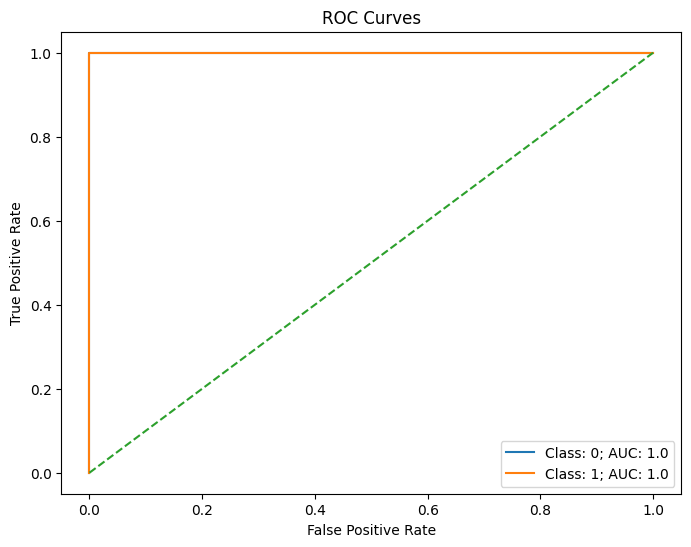

In [35]:
cm_roc_report(model_lr, testX, testY, RFE_selected_features, test_data = True)

The test accuracy along with cross-validation has not changed. 

#### vi. Separation

As indicated by the p-value analysis in the [statsmodel] output, the data exhibits complete separation. This is further supported by the confusion matrices and ROC curves, which show that the classes are too well-separated, leading to instability in the logistic regression parameters

#### vii. Imbalance

In [36]:
split_range = 20
Oversampling_result = {'Split': [], 'Count of Features': [], 'Test Accuracy': [], 'Test Error': []}
for split in range(1, split_range + 1):
    model, selector, score, error = logistic_regression(train_data_map, test_data_map, split, cv_fold, oversampling = True, features = features)
    Oversampling_result['Split'].append(split)
    Oversampling_result['Count of Features'].append(selector.n_features_)
    Oversampling_result['Test Accuracy'].append(score)
    Oversampling_result['Test Error'].append(error)

Oversampling_result = pd.DataFrame(Oversampling_result)
Oversampling_result

Split  Count of Features  Test Accuracy  Test Error
0       1                 11        0.97500     0.02500
1       2                 14        0.97500     0.02500
2       3                  6        0.98333     0.01667
3       4                  3        0.98333     0.01667
4       5                  6        0.98333     0.01667
5       6                  2        0.99167     0.00833
6       7                  6        0.98333     0.01667
7       8                 10        0.98333     0.01667
8       9                  3        1.00000     0.00000
9      10                  5        0.99167     0.00833
10     11                  2        0.99167     0.00833
11     12                  4        0.99167     0.00833
12     13                  7        1.00000     0.00000
13     14                  5        0.99167     0.00833
14     15                  6        0.99167     0.00833
15     16                  3        0.99167     0.00833
16     17                 17        1.00000     0.00000
17     18                 13        1.00000     0.00000
18     19                  3        0.99167     0.00833
19     20                  6        1.00000     0.00000

ROC Curve for train data

Confusion Matrix:
[[60  0]
 [ 0 60]]
Accuracy: 1.0000


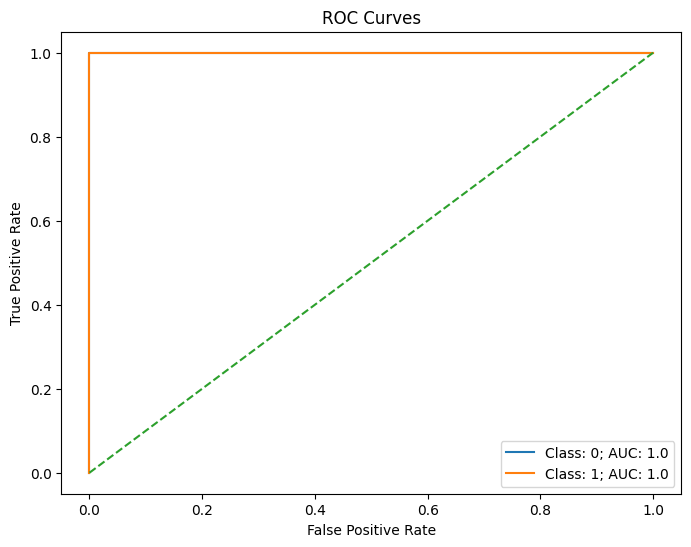

In [38]:
top_oversample_res = Oversampling_result['Test Accuracy'].argmax()
split = top_oversample_res + 1
headers = extract_features(time_series_columns, features, split)
model_oversampling_lr, selector, score, error = logistic_regression(train_data_map, test_data_map, split, cv_fold, oversampling = True, features = features)
train_df = modify_data(train_data_map, split, headers, time_series_columns, features)  
train_df = oversample_imbalance_class(train_df)
trainX, trainY = train_df.iloc[:, :-1], train_df.iloc[:, -1]
print("ROC Curve for train data\n")
cm_roc_report(model_oversampling_lr, trainX, trainY, RFE_selected_features)

ROC Curve for test data

Confusion Matrix:
[[15  0]
 [ 0  4]]
Accuracy: 1.0000


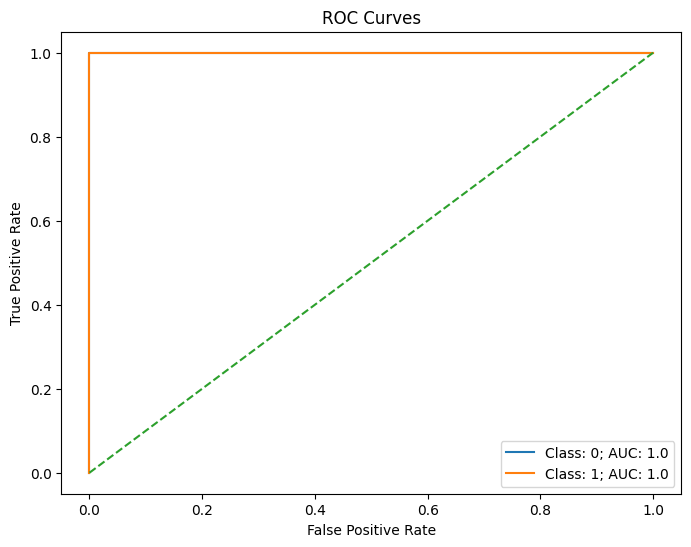

In [39]:
print("ROC Curve for test data\n")
cm_roc_report(model_oversampling_lr, testX, testY, RFE_selected_features)

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [52]:
def logistic_regression_classification(train_data_map, test_data_map, split, time_series=time_series_columns, features=time_domain_features, cv_fold=None, is_binary=False, is_gaussian=False, is_multinomial=False, is_multinomial_nb=False):
    
    headers = extract_features(time_series_columns, features, split)
    
    # Prepare train and test data
    train_df = modify_data(train_data_map, split, headers, time_series, features, is_binary)
    test_df = modify_data(test_data_map, split, headers, time_series, features, is_binary)
    trainX, trainY = train_df.iloc[:, :-1], train_df.iloc[:, -1]
    testX, testY = test_df.iloc[:, :-1], test_df.iloc[:, -1]
    random_state = 69 if cv_fold is not None else None
    
    # Logistic regression for binary classification
    if is_binary:
        model = LogisticRegressionCV(
            penalty='l1', max_iter=100, scoring='accuracy', 
            cv=cv_fold, random_state=random_state, solver='liblinear')
        model.fit(trainX, trainY)
        best_C_index = np.argmax(model.scores_[1].mean(axis=0))
        train_score = np.mean(model.scores_[1][:, best_C_index])
    
    # Gaussian Naive Bayes classification
    elif is_gaussian:
        model = GaussianNB()
        model.fit(trainX, trainY)
        train_score = cross_val_score(
            estimator=model, X=trainX, y=trainY, 
            cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True), 
            scoring="accuracy").mean()
    
    # Multinomial classification with logistic regression
    elif is_multinomial:
        model = LogisticRegressionCV(
        penalty='l1', max_iter=100, multi_class='multinomial', 
        cv=cv_fold, random_state=random_state, solver='saga')
        model.fit(trainX, trainY)
        # Find the best C index directly within the multinomial block
        best_C_index = None
        find_C = model.C_[0]
        # Iterate through the Cs_ array to find the index where the best C is located
        for i, c in enumerate(model.Cs_):
            if c == find_C:
                best_C_index = i
                break  # Once we find the index, break out of the loop
        # If no matching index is found, raise an error (safety check)
        if best_C_index is None:
            raise ValueError("Best C value not found in Cs_ array.")
        # Calculate the average train score for all classes using the best C index
        score = 0
        for class_ in model.scores_.keys():
            score += np.mean(model.scores_[class_][:, best_C_index])
        train_score = score / len(model.scores_.keys())
        
    elif is_multinomial_nb:
        model = MultinomialNB()
        model.fit(trainX, trainY)
        score = cross_val_score(estimator=model, X=trainX, y=trainY, 
            cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True), 
            scoring="accuracy")
        train_score = np.mean(score)
    
    # Train error calculation
    train_error = round((1 - train_score), 4)
    
    return model, trainX, trainY, testX, testY, train_score, train_error


In [41]:
def plot_roc_and_confusion_matrix(model, trainX, trainY, testX, testY, selected_features):
    # Predict and get probabilities for train and test sets
    train_predict = model.predict_proba(trainX)
    test_predict = model.predict_proba(testX)
    # Test Confusion Matrix
    print(f"Confusion Matrix for Test Data:")
    print(confusion_matrix(testY, model.predict(testX)))
    
    # Plot ROC Curves for train
    print("ROC Curve for Train Data")
    _, axes = plt.subplots(figsize=(8, 6))
    axes.set_title("ROC Curves")
    for i, class_ in enumerate(model.classes_):
        y_pred_train = train_predict[:, i]
        fpr, tpr, _ = roc_curve(trainY, y_pred_train, pos_label=class_)
        roc_auc = auc(fpr, tpr)
        axes.plot(fpr, tpr, label=f"Class: {class_}; AUC: {round(roc_auc, 4)}")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

    # Plot ROC Curves for test
    print("ROC Curve for Test Data")
    _, axes = plt.subplots(figsize=(8, 6))
    axes.set_title("ROC Curves")
    for i, class_ in enumerate(model.classes_):
        y_pred_test = test_predict[:, i]
        fpr, tpr, _ = roc_curve(testY, y_pred_test, pos_label=class_)
        roc_auc = auc(fpr, tpr)
        axes.plot(fpr, tpr, label=f"Class: {class_}; AUC: {round(roc_auc, 4)}")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()


    Split  Train Score  Train Error
0       1     0.942857       0.0571
1       2     0.942857       0.0571
2       3     0.928571       0.0714
3       4     0.928571       0.0714
4       5     0.928571       0.0714
5       6     0.942857       0.0571
6       7     0.928571       0.0714
7       8     0.928571       0.0714
8       9     0.942857       0.0571
9      10     0.942857       0.0571
10     11     0.957143       0.0429
11     12     0.957143       0.0429
12     13     0.957143       0.0429
13     14     0.942857       0.0571
14     15     0.942857       0.0571
15     16     0.957143       0.0429
16     17     0.942857       0.0571
17     18     0.957143       0.0429
18     19     0.957143       0.0429
19     20     0.971429       0.0286
Best Split:  20
Train Data ROC Curve and Confusion Matrix:
Confusion Matrix for Test Data:
[[15  0]
 [ 1  3]]
ROC Curve for Train Data


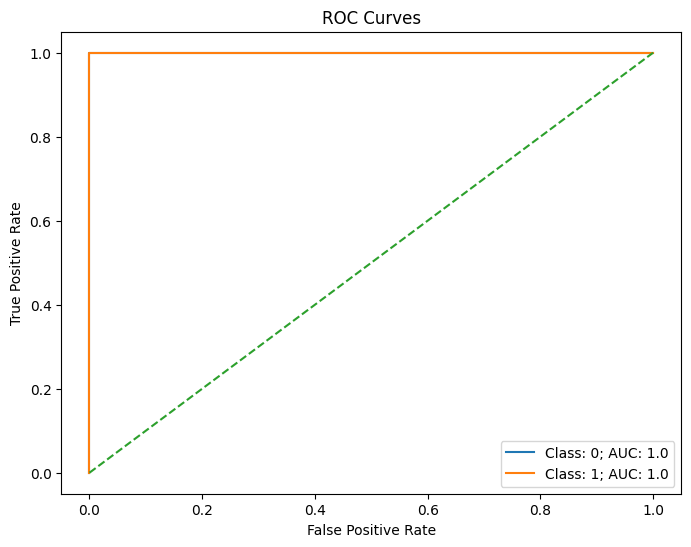

ROC Curve for Test Data


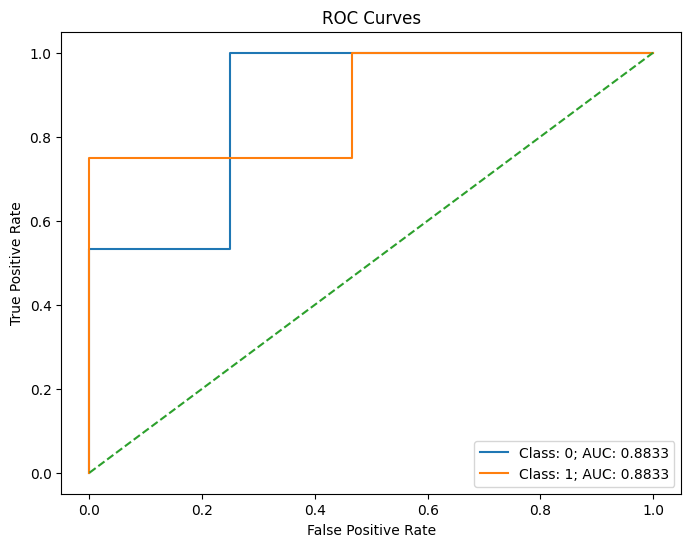

In [42]:
# Setting the parameters for binary classification
cv_fold = 5
split_range = 20
LR_result = []

# Selected features for the model
selected_features = ['mean', '50%', 'std']

# Perform logistic regression for each split (l = 1 to 20) with binary classification
for split in range(1, split_range + 1):
    # Call logistic_regression_classification with binary flag set to True
    model, trainX, trainY, testX, testY, train_score, train_error = logistic_regression_classification(
        train_data_map, test_data_map, split, 
        cv_fold=cv_fold, is_binary=True, features=selected_features  # is_binary=True for binary classification
    )
    
    # Append results for each split
    LR_result.append([split, train_score, train_error])

# Convert results to a DataFrame for analysis
LR_result = pd.DataFrame(LR_result, columns=['Split', 'Train Score', 'Train Error'])

# Display the result table for analysis
print(LR_result)

# Identify the best split based on the highest train accuracy
best_split = LR_result['Train Score'].idxmax() + 1  # Get the best split index (split starts from 1)
model, trainX, trainY, testX, testY, _, _ = logistic_regression_classification(
    train_data_map, test_data_map, best_split, 
    cv_fold=cv_fold, is_binary=True, features=selected_features  # Ensure it's binary classification
)

print("Best Split: ", best_split)

# Plot ROC curves and display confusion matrix for train and test data
print("Train Data ROC Curve and Confusion Matrix:")
plot_roc_and_confusion_matrix(model, trainX, trainY, testX, testY, selected_features)

Best model with split = 20, max_test_accuracy = 0.971429

#### ii. Comparison

- L1-penalized logistic regression performs worse for accuracy of test data, as we can see that the one with p-values had 100% of test accuracy where the one with L1-penalized regression with 97.14% accuracy.
- L1-penalized logistic regression is easier to implement as the process is automated and not manual where variable selection using p-values requires more manual work. 

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

    Split  Train Score  Train Error
0       1     0.871429       0.1286
1       2     0.871429       0.1286
2       3     0.827473       0.1725
3       4     0.812088       0.1879
4       5     0.754945       0.2451
5       6     0.754945       0.2451
6       7     0.754945       0.2451
7       8     0.710989       0.2890
8       9     0.739560       0.2604
9      10     0.725275       0.2747
10     11     0.710989       0.2890
11     12     0.724176       0.2758
12     13     0.710989       0.2890
13     14     0.724176       0.2758
14     15     0.725275       0.2747
15     16     0.710989       0.2890
16     17     0.709890       0.2901
17     18     0.695604       0.3044
18     19     0.709890       0.2901
19     20     0.725275       0.2747
Best Split:  1
Train Data ROC Curve and Confusion Matrix:
Confusion Matrix for Test Data:
[[2 0 0 0 0 0 0]
 [1 0 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


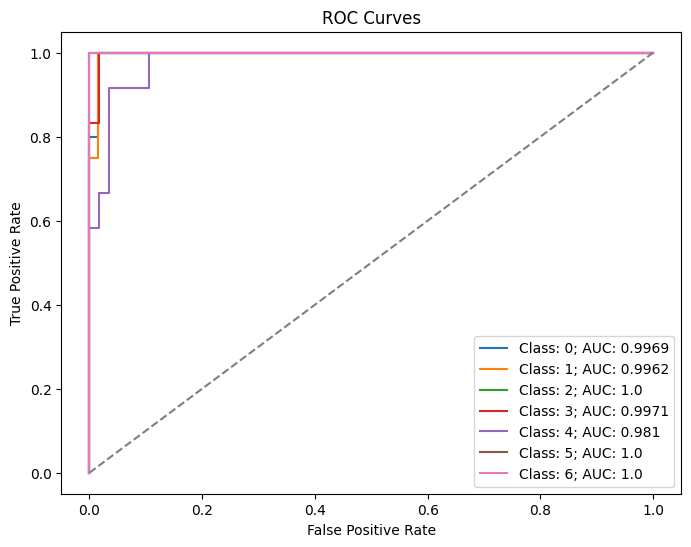

ROC Curve for Test Data


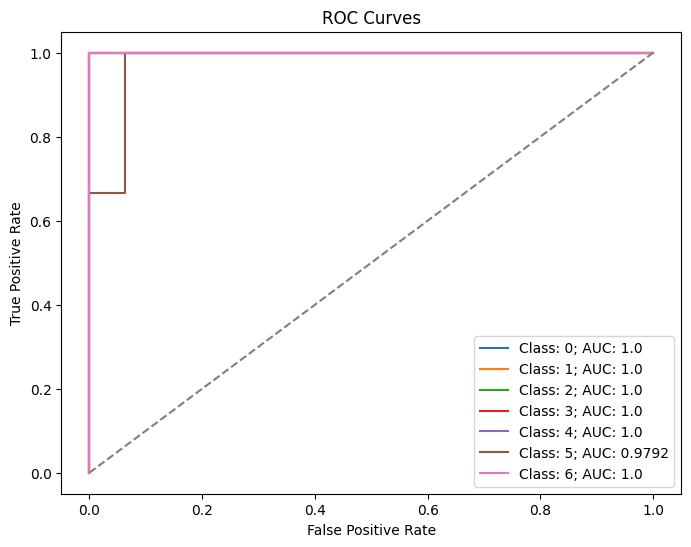

In [53]:
selected_features = ['mean', '50%', 'std']
cv_fold = 5
split_range = 20
LR_result = []

# Perform multinomial logistic regression for each split (l = 1 to 20)
for split in range(1, split_range + 1):
    model, trainX, trainY, testX, testY, train_score, train_error = logistic_regression_classification(
        train_data_map, test_data_map, split, 
        cv_fold=cv_fold, is_multinomial=True, features=selected_features  # Use is_multinomial=True
    )
    
    # Append results for each split
    LR_result.append([split, train_score, train_error])

# Convert results to a DataFrame for analysis
LR_result = pd.DataFrame(LR_result, columns=['Split', 'Train Score', 'Train Error'])

# Display the result table for analysis
print(LR_result)

# Identify the best split based on the highest train accuracy
best_split = LR_result['Train Score'].idxmax() + 1  # Get the best split index (split starts from 1)
model, trainX, trainY, testX, testY, _, _ = logistic_regression_classification(
    train_data_map, test_data_map, best_split, 
    cv_fold=cv_fold, is_multinomial=True, features=selected_features
)

print("Best Split: ", best_split)
# Plot ROC curves and display confusion matrix for train and test data
print("Train Data ROC Curve and Confusion Matrix:")
plot_roc_and_confusion_matrix(model, trainX, trainY, testX, testY, selected_features)


#### ii. Naive Bayes

    Split  Train Score  Train Error
0       1     0.870330       0.1297
1       2     0.797802       0.2022
2       3     0.768132       0.2319
3       4     0.770330       0.2297
4       5     0.753846       0.2462
5       6     0.681319       0.3187
6       7     0.710989       0.2890
7       8     0.724176       0.2758
8       9     0.709890       0.2901
9      10     0.767033       0.2330
10     11     0.752747       0.2473
11     12     0.753846       0.2462
12     13     0.624176       0.3758
13     14     0.754945       0.2451
14     15     0.726374       0.2736
15     16     0.696703       0.3033
16     17     0.712088       0.2879
17     18     0.769231       0.2308
18     19     0.754945       0.2451
19     20     0.710989       0.2890
Best Split:  1
Max_test_accuracy:  0.8703296703296705
Train Data ROC Curve and Confusion Matrix:
Confusion Matrix for Test Data:
[[2 0 0 0 0 0 0]
 [0 1 0 0 1 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 0

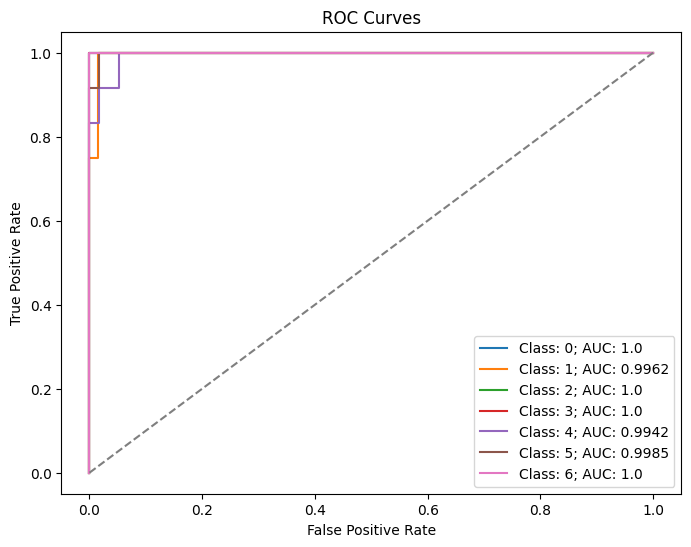

ROC Curve for Test Data


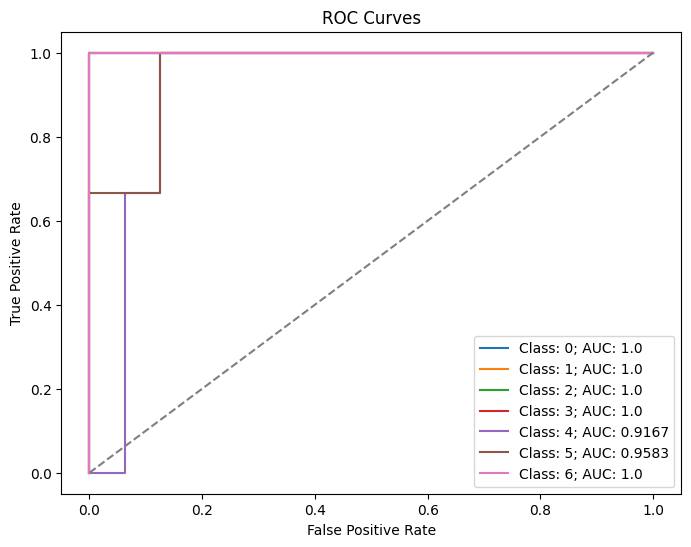

In [44]:
cv_fold = 5
split_range = 20
NB_result = []

# Perform Naive Bayes (Gaussian) classification for each split (l = 1 to 20)
for split in range(1, split_range + 1):
    model, trainX, trainY, testX, testY, train_score, train_error = logistic_regression_classification(
        train_data_map, test_data_map, split, 
        cv_fold=cv_fold, is_gaussian=True, features=selected_features  # Use is_gaussian=True for Naive Bayes
    )
    
    # Append results for each split
    NB_result.append([split, train_score, train_error])

# Convert results to a DataFrame for analysis
NB_result = pd.DataFrame(NB_result, columns=['Split', 'Train Score', 'Train Error'])

# Display the result table for analysis
print(NB_result)

# Identify the best split based on the highest train accuracy
best_split = NB_result['Train Score'].idxmax() + 1  # Get the best split index (split starts from 1)
model, trainX, trainY, testX, testY, _, _ = logistic_regression_classification(
    train_data_map, test_data_map, best_split, 
    cv_fold=cv_fold, is_gaussian=True, features=selected_features  # Ensure it's Naive Bayes for this part
)

print("Best Split: ", best_split)
print("Max_test_accuracy: ", NB_result['Train Score'].max())
# Plot ROC curves and display confusion matrix for train and test data
print("Train Data ROC Curve and Confusion Matrix:")
plot_roc_and_confusion_matrix(model, trainX, trainY, testX, testY, selected_features)


    Split  Train Score  Train Error
0       1     0.825275       0.1747
1       2     0.826374       0.1736
2       3     0.812088       0.1879
3       4     0.827473       0.1725
4       5     0.840659       0.1593
5       6     0.797802       0.2022
6       7     0.783516       0.2165
7       8     0.783516       0.2165
8       9     0.769231       0.2308
9      10     0.769231       0.2308
10     11     0.783516       0.2165
11     12     0.783516       0.2165
12     13     0.783516       0.2165
13     14     0.783516       0.2165
14     15     0.769231       0.2308
15     16     0.769231       0.2308
16     17     0.754945       0.2451
17     18     0.783516       0.2165
18     19     0.740659       0.2593
19     20     0.754945       0.2451
Best Split:  5
Max_test_accuracy:  0.8406593406593406
Train Data ROC Curve and Confusion Matrix:
Confusion Matrix for Test Data:
[[2 0 0 0 0 0 0]
 [2 0 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0

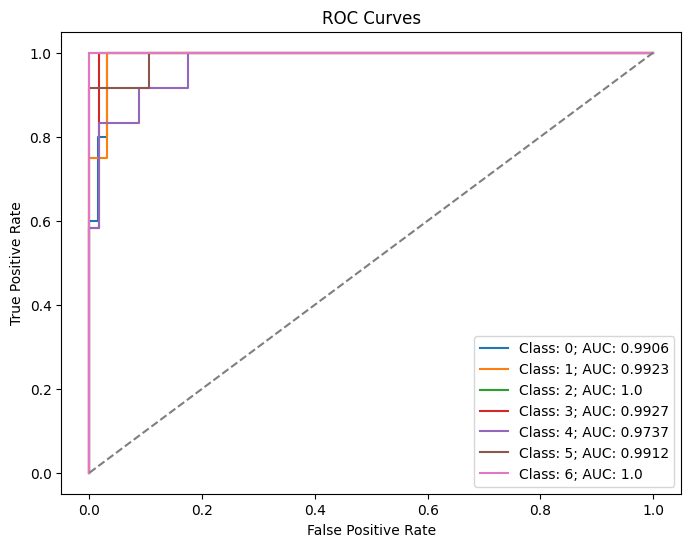

ROC Curve for Test Data


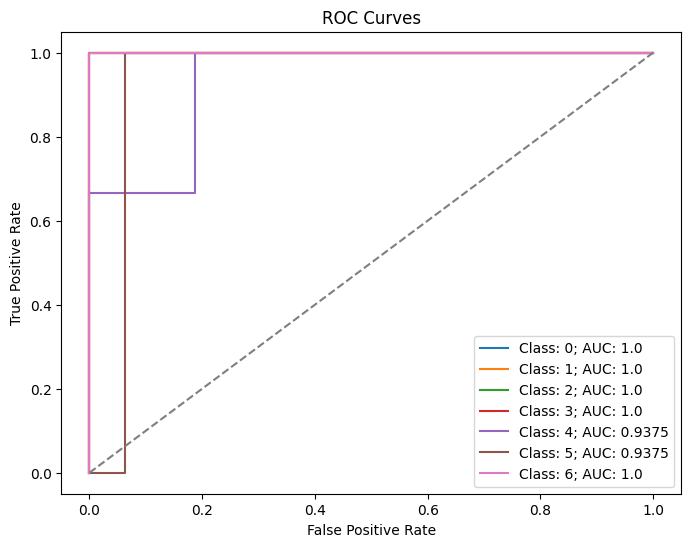

In [45]:
cv_fold = 5
split_range = 20
LR_result = []

# Perform multinomial logistic regression for each split (l = 1 to 20)
for split in range(1, split_range + 1):
    model, trainX, trainY, testX, testY, train_score, train_error = logistic_regression_classification(
        train_data_map, test_data_map, split, 
        cv_fold=cv_fold, is_multinomial_nb=True, features=selected_features
    )
    
    # Append results for each split
    LR_result.append([split, train_score, train_error])

# Convert results to a DataFrame for analysis
LR_result = pd.DataFrame(LR_result, columns=['Split', 'Train Score', 'Train Error'])

# Display the result table for analysis
print(LR_result)

# Identify the best split based on the highest train accuracy
best_split = LR_result['Train Score'].idxmax() + 1  # Get the best split index (split starts from 1)
model, trainX, trainY, testX, testY, _, _ = logistic_regression_classification(
    train_data_map, test_data_map, best_split, 
    cv_fold=cv_fold, is_multinomial_nb=True, features=selected_features
)

print("Best Split: ", best_split)
print("Max_test_accuracy: ", LR_result['Train Score'].max())
# Plot ROC curves and display confusion matrix for train and test data
print("Train Data ROC Curve and Confusion Matrix:")
plot_roc_and_confusion_matrix(model, trainX, trainY, testX, testY, selected_features)


#### ii. Comparison

In Naive Bayes is_Guassian has best split at 1 with test accuracy ~0.8703 while is_multimodal_nb (multimodal prior) has best split at 5 with test accuracy ~0.8401. Thus guassian performs better. 

## 3. ISLR 4.8.3

Bayes' theorem follows: 
$$ P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)} $$

Posterior probability of the Bayes' classifier:
$$ P_k(x) = \frac{\pi_k f_k(x)}{\sum_{l=1}^{K} \pi_l f_l(x)} $$

Substituting the Gaussian distribution:
$$
P_k(x) = \frac{\pi_k \frac{1}{\sigma_k \sqrt{2\pi}} \exp\left( -\frac{1}{2\sigma_k^2} (x - \mu_k)^2 \right)}{\sum_{l=1}^{K} \pi_l \frac{1}{\sigma_l \sqrt{2\pi}} \exp\left( -\frac{1}{2\sigma_l^2} (x - \mu_l)^2 \right)}
$$

Taking the logarithm of both sides and simplifying:
$$
\alpha_k = -\frac{1}{2\sigma_k^2}(x - \mu_k)^2
$$

Thus:
$$
P_k(x) = \ln \left( \frac{\pi_k}{\sigma_k} e^{\alpha_k} \right) - \ln \left( \sum_{l=1}^{K} \frac{\pi_l}{\sigma_l} e^{\alpha_l} \right)
$$

Simplifying:
$$
\ln P_k(x) = \ln \frac{\pi_k}{\sigma_k} + \alpha_k - \ln \left( \sum_{l=1}^{K} \frac{\pi_l}{\sigma_l} e^{\alpha_l} \right)
$$

Here we can visualize that the decision boundary is not linear because of the quadratic $x^{2}$ term. Instead, decision boudary is quadratic when the variances $\sigma_K^2$ are allowed to differ for each class. 



## 4. ISLR 4.8.7

The problem can be expressed in the equation below:

$$
P_k(Y = \text{"Yes" or "No"} \mid X = \text{last year’s percent profit}) = \frac{\pi_k \cdot f_k(x)}{\sum_{l=1}^{2} \pi_l \cdot f_l(x)}
$$

Where "Yes" or "No" are referring to the stock probability to issue a dividend or not.

Given:
\begin{align*}
\mu_{\text{Yes}} &= 10 \quad &\text{(mean for companies issuing dividends)} \\
\mu_{\text{No}}  &= 0  \quad &\text{(mean for companies not issuing dividends)} \\
\sigma^2 &= 36  \quad &\text{(variance for both classes)} \\
\pi_{\text{Yes}} &= 0.8  \quad &\text{(prior probability of issuing dividends)} \\
\pi_{\text{No}}  &= 0.2  \quad &\text{(prior probability of not issuing dividends)}
\end{align*}

The probability for a company with \( X = 4 \) (percent profit) to issue a dividend is:

$$
P_k(Y = \text{"Yes"} \mid X = 4) = \frac{\pi_{\text{Yes}} \cdot f_{\text{Yes}}(4)}{\pi_{\text{Yes}} \cdot f_{\text{Yes}}(4) + \pi_{\text{No}} \cdot f_{\text{No}}(4)}
$$

Calculating the density function for $f_{\text{Yes}}(4)$:

$$
f_{\text{Yes}}(4) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left( -\frac{1}{2\sigma^2}(x - \mu_{\text{Yes}})^2 \right)
$$

Plugging in the numbers:

$$
f_{\text{Yes}}(4) = \frac{1}{6\sqrt{2\pi}} \exp\left( -\frac{1}{2 \cdot 36}(4 - 10)^2 \right) = 0.040325
$$

For $f_{\text{No}}(4)$:

$$
f_{\text{No}}(4) = \frac{1}{6\sqrt{2\pi}} \exp\left( -\frac{1}{2 \cdot 36}(4 - 0)^2 \right) = 0.053325
$$

Final Calculation using Bayes' Theorem:

$$
P_{\text{Yes}}(Y = \text{"Yes"} \mid X = 4) = \frac{0.8 \cdot 0.040325}{0.8 \cdot 0.040325 + 0.2 \cdot 0.053325} = 0.752
$$

Thus, the probability of issuing a dividend is \( 75.2\% \).



## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9

## Citations


- https://medium.com/@rithpansanga/logistic-regression-for-feature-selection-selecting-the-right-features-for-your-model-410ca093c5e0#:~:text=Recursive%20Feature%20Elimination%20(RFE)%20is,the%20desired%20number%20of%20features.
- https://www.statsmodels.org/stable/index.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
- https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
- https://scikit-learn.org/dev/modules/generated/sklearn.naive_bayes.MultinomialNB.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba


## ChatGPT prompts & responses

### Prompt: 
referring this implementation of RFE logistic regression: https://medium.com/@rithpansanga/logistic-regression-for-feature-selection-selecting-the-right-features-for-your-model-410ca093c5e0#:~:text=Recursive%20Feature%20Elimination%20(RFE)%20is,the%20desired%20number%20of%20features. can you provide me a skeleton of logistic regression? I want to check for oversampling as well, that in oversampling/balancing function should use resample(). thus, provide me skeleton with combined function for logistic regression that checks for oversampling. 


In [ ]:
# Required libraries
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

def logistic_regression_with_oversampling(train_data, test_data, target_col, num_features=5, oversample=True):
    """
    Perform Logistic Regression with Recursive Feature Elimination (RFE) while handling class imbalance using resample().

    Parameters:
    train_data (DataFrame): The training dataset containing features and target.
    test_data (DataFrame): The testing dataset containing features and target.
    target_col (str): The column name for the target variable.
    num_features (int): Number of features to select via RFE.
    oversample (bool): Whether to perform oversampling to balance the dataset.

    Returns:
    dict: Dictionary containing model performance metrics and selected features.
    """
    # Separate features and target
    X_train = train_data.drop(columns=[target_col])
    y_train = train_data[target_col]
    
    X_test = test_data.drop(columns=[target_col])
    y_test = test_data[target_col]

    # Perform oversampling if required
    if oversample:
        # Class distribution
        class_0 = train_data[train_data[target_col] == 0]
        class_1 = train_data[train_data[target_col] == 1]
        
        # Resample minority class
        if len(class_0) > len(class_1):
            class_1_resampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)
            balanced_train_data = pd.concat([class_0, class_1_resampled])
        else:
            class_0_resampled = resample(class_0, replace=True, n_samples=len(class_1), random_state=42)
            balanced_train_data = pd.concat([class_0_resampled, class_1])
        
        # Shuffle the balanced dataset
        balanced_train_data = balanced_train_data.sample(frac=1).reset_index(drop=True)
        
        # Update training data after oversampling
        X_train = balanced_train_data.drop(columns=[target_col])
        y_train = balanced_train_data[target_col]

    # Initialize the Logistic Regression model
    model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
    
    # Perform Recursive Feature Elimination (RFE)
    rfe = RFE(estimator=model, n_features_to_select=num_features)
    rfe.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    X_test_selected = X_test[X_train.columns[rfe.support_]]
    y_pred = rfe.predict(X_test_selected)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    return {
        "model": rfe,
        "accuracy": test_accuracy,
        "selected_features": X_train.columns[rfe.support_]
    }

# Example usage
train_data = pd.DataFrame(...)  # Load your train data
test_data = pd.DataFrame(...)   # Load your test data

# Perform Logistic Regression with RFE and Oversampling
results = logistic_regression_with_oversampling(
    train_data=train_data, 
    test_data=test_data, 
    target_col='target', 
    num_features=5, 
    oversample=True
)

# Display results
print(f"Selected Features: {results['selected_features']}")
print(f"Test Accuracy: {results['accuracy']}")


### Prompt:
how do i plot roc with auc and find confusion matrix?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Load data
data = load_iris()
X = data.data
y = data.target

# For binary classification, select two classes (0 and 1)
X = X[y != 2]
y = y[y != 2]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Get predicted probabilities for ROC curve
y_prob = model.predict_proba(X_test)[:, 1]  # For binary classification

# Predict class labels for the confusion matrix
y_pred = model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Compute and print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

### Prompt: 
for logistic regression, how can i replace p-values for variable selection with L1 regulization?

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

# Train logistic regression with L1 penalty for variable selection
def logistic_regression_with_L1(trainX, trainY, cv_fold=5):
    # Logistic Regression with L1 regularization (Lasso)
    model = LogisticRegressionCV(
        penalty='l1',  # L1 penalty for variable selection
        solver='liblinear',  # Solver that supports L1 penalty
        cv=cv_fold,  # Cross-validation to find the best regularization strength
        max_iter=100,  # Max iterations for convergence
        scoring='accuracy',  # Scoring metric
        random_state=69
    )
    
    # Fitting the model
    model.fit(trainX, trainY)
    
    # Best C (regularization strength)
    best_C_index = np.argmax(model.scores_[1].mean(axis=0))  # For binary classification
    train_score = np.mean(model.scores_[1][:, best_C_index])
    
    return model, train_score

In [ ]:
# Example usage
selected_features = ['mean', '50%', 'std']
cv_fold = 5

# Assume trainX and trainY are the training data and labels
model, train_score = logistic_regression_with_L1(trainX, trainY, cv_fold)

# Print train score
print(f"Train Accuracy with L1 Regularization: {train_score:.4f}")

# Get selected features based on non-zero coefficients
selected_features = get_selected_features(model, selected_features)

### prompt:
how can i apply multimodal and guassian to logistic regression?

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

# Multinomial Logistic Regression with L1 regularization
def logistic_regression_multinomial(trainX, trainY, cv_fold=5):
    # Logistic Regression with L1 regularization and multinomial setting
    model = LogisticRegressionCV(
        penalty='l1',  # L1 regularization for variable selection
        solver='saga',  # Solver that supports multinomial and L1 penalty
        multi_class='multinomial',  # Multinomial logistic regression
        cv=cv_fold,  # Cross-validation
        max_iter=100,  # Maximum iterations for convergence
        scoring='accuracy',  # Scoring based on accuracy
        random_state=69
    )
    
    # Fitting the model
    model.fit(trainX, trainY)
    
    # Find the best C (regularization strength)
    best_C_index = np.argmax(model.scores_[model.classes_[0]].mean(axis=0))
    train_score = np.mean(model.scores_[model.classes_[0]][:, best_C_index])
    
    return model, train_score

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Gaussian Naive Bayes Classification
def gaussian_naive_bayes(trainX, trainY):
    model = GaussianNB()  # Gaussian Naive Bayes Model
    model.fit(trainX, trainY)  # Fit the model
    
    # Perform cross-validation and compute accuracy
    train_score = cross_val_score(
        estimator=model, 
        X=trainX, 
        y=trainY, 
        cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True), 
        scoring="accuracy"
    ).mean()
    
    return model, train_score

### Prompt:
how do i get multinomial naive bayes in logistic regression?

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, StratifiedKFold

def logistic_regression_classification(train_data_map, test_data_map, split, time_series=time_series_columns, features=time_domain_features, 
                                       cv_fold=None, is_binary=False, is_gaussian=False, is_multinomial_nb=False):
    # Prepare features
    headers = extract_features(time_series_columns, features, split)
    
    # Prepare train and test data
    train_df = modify_data(train_data_map, split, headers, time_series, features, is_binary)
    test_df = modify_data(test_data_map, split, headers, time_series, features, is_binary)
    
    trainX, trainY = train_df.iloc[:, :-1], train_df.iloc[:, -1]
    testX, testY = test_df.iloc[:, :-1], test_df.iloc[:, -1]
    
    # Random state for reproducibility
    random_state = 69 if cv_fold is not None else None
    
    # Apply Multinomial Naive Bayes
    if is_multinomial_nb:
        model = MultinomialNB()
        model.fit(trainX, trainY)
        
        # Cross-validation score for train score
        score = cross_val_score(
            estimator=model, X=trainX, y=trainY, 
            cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True), 
            scoring="accuracy"
        )
        train_score = score.mean()
    
    # Train error calculation
    train_error = round((1 - train_score), 4)
    
    return model, trainX, trainY, testX, testY, train_score, train_error
